In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
from orphics import maps, cosmology, io, stats
from enlib import enmap, bench
import numpy as np
from szar import counts

In [54]:
shape,wcs = maps.rect_geometry(width_arcmin=10.,px_res_arcmin=0.5)
print(shape)

(20, 20)


In [55]:
# Theory
theory_file_root = "../../alhazen/data/Aug6_highAcc_CDM"
cc = counts.ClusterCosmology(skipCls=True)
theory = cosmology.loadTheorySpectraFromCAMB(theory_file_root,unlensedEqualsLensed=False,                                                    useTotal=False,TCMB = 2.7255e6,lpad=9000,get_dimensionless=False)


In [56]:
modlmap = enmap.modlmap(shape,wcs)
modrmap = enmap.modrmap(shape,wcs)

power2d = theory.uCl('TT',modlmap)
with bench.show("pixcov"):
    fcov = maps.diagonal_cov(power2d)
    Ucov = maps.pixcov(shape,wcs,fcov)

 0.03  2.39  2.66 pixcov


In [57]:
print(Ucov.shape)

(20, 20, 20, 20)


In [58]:
Ucov = Ucov.reshape((np.prod(shape),np.prod(shape)))

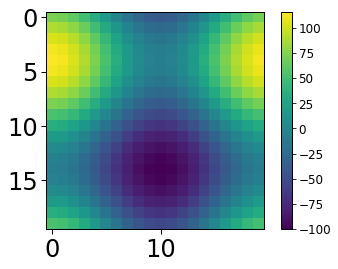

In [59]:
io.plot_img(Ucov[-100,:].reshape(shape))

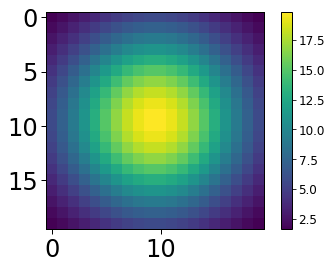

(20, 20) (20, 20) (400, 400)


In [60]:
sigma = 3.0*np.pi/180./60.
prof = 20.*np.exp(-modrmap**2./2./sigma**2.)
io.plot_img(prof)
print(shape,prof.shape,Ucov.shape)

 0.01  2.39  2.66 cinv
 0.01  2.39  2.66 pcinv
 0.01  2.39  2.66 pcinv2


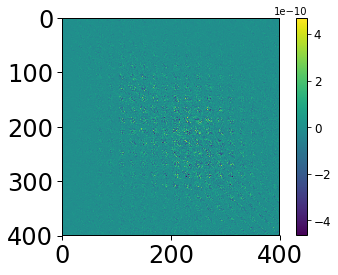

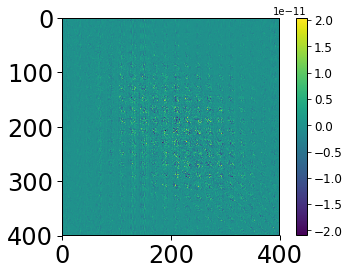

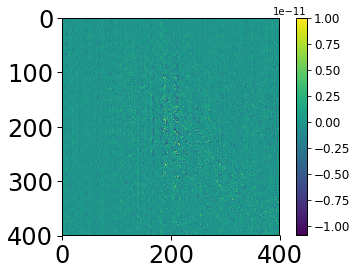

In [61]:
from scipy.linalg import pinv2
#invf = pinv2
#invf = np.linalg.pinv
invf = np.linalg.inv

Cov = Ucov + maps.ncov(shape,wcs,0.1) 
with bench.show("cinv"):
    Cinv = invf(Cov)
Cov = Ucov + maps.ncov(shape,wcs,0.1) + np.outer(prof.ravel(),prof.ravel()) 
with bench.show("pcinv"):
    CinvP = invf(Cov)
with bench.show("pcinv2"):
    CinvP2 = stats.sm_update(Cinv,prof.ravel())
io.plot_img(CinvP-CinvP2,flip=False)
io.plot_img(np.dot(Cov,CinvP)-np.identity(Cov.shape[0]),flip=False)
io.plot_img(np.dot(Cov,CinvP2)-np.identity(Cov.shape[0]),flip=False)